# Algorithm Design
Design your own algorithms for the detection of green grass, water clouds, and urban-residential areas using the reflectance data of water and ice clouds, sand, grass, soil, urban-residential areas, and water within the .4 - 2.5 micrometer spectrum.

## Satellite
This will focus on using LANDSAT 8 data and bottom of atmosphere reflectance (i.e., after atmospheric correction has been applied).

### Green Grass
With "green grass", the spectral response function is heavily driven by chlorophyll's highly absorptive nature in the visible spectrum. Chlorophyll is very absorptive in the blue and red portions of the visible spectrum; however, it is reflective in the green portion of the visible spectrum. Most important for chlorophyll is the red-edge region, which is a region around .7 micrometers where the reflectance experiences a very sharp change. Therefore, any problem approaching green grass must factor in the response at ~ .8 micrometers (starting at .7 micrometers).

For green grass, the following approximate wavelengths would be great:
- .8 micrometers, sudden change in reflectance
- .4 micrometers, highly absorptive
- .55 micrometers, green: slightly reflective
- 2.2 micrometers, slightly reflective but very absorptive

The response at .4 micrometers will allow distinguishing between ice clouds and water clouds. The response at .8 will allow distinguishing water, soil, and urban-residential. The response at 2.2 will allow distinguishing sand and green grass.

### Water Clouds
Water clouds have a similar response function to ice clouds; however, they are rather distinct from the other categories in the visible spectrum. They are very reflective in the visible spectrum and parts of the near infrared. Ice clouds are also called Cirrus clouds, and they are best differentiated 

For water clouds, the following approximate wavelengths would be great:
- Anywhere from .4 to .7 micrometers, due to its' high reflectance.
- 1.4 or 1.6 micrometers.
The response in 1.6 would allow some differentiation between water and ice clouds. 

### Urban-Residential
Urban-residential is very absorptive in the visible spectrum. Similar to grass, it becomes more reflective in the near infrared, although it is not nearly as reflective. 

For urban-residential, the following approximate wavelengths would be great:
- .8 micrometers
- 1.9 micrometers

Capturing at .8 will allow differentiating between water, soil, grass, and clouds. Capturing at 1.9 micrometers will allow allow additional distinguishing between sand, soil, water, and clouds.


### Actual Landsat Bands
Now that they generic parameters have been identified, it is time to identify the exact bands to use in the land cover classification.

Green Grass:
- Band 3: 

Water Clouds:
- Band 9, the "Cirrus" band

### Comparison Vectors
Green Grass: 
- Lawn_Grass GDS91 green DESCRIPT
- https://crustal.usgs.gov/speclab/data/HTMLmetadata/Lawn_Grass_GDS91_green_BECKa_AREF.html
Water Clouds:

Urban-Residential:


In [551]:
import cupy as cp  
import fiona
import geopandas as gpd
from json import load # maintaining a data.json for spectrometer and assorted information that may be repeatable
import landsatxplore as lsxp
from landsatxplore import earthexplorer as ee 
import keyring # api username/password stored in windows credential manager
import matplotlib.pyplot as plt
from math import cos, sin, pi
import numpy as np 
import os
from osgeo import gdal
import rasterio
from rasterio.plot import show_hist
from shapely.geometry import Polygon

# custom imports
from spectral import Spectrometer, Sample

fiona.supported_drivers['KML'] = 'rw' # yuck - remove + fiona when arcgis license comes through

In [5]:
spectral_data = open(r'../data/data.json')
spectrometers = load(spectral_data)['spectrometers']
spectrometers = [Spectrometer(**spec) for spec in spectrometers] # custom class
spectrometers[0]

'Spectrometer(spectrometer_code=BECK, wavelength_min=0.2,wavelength_max=3,bandpass_descrip=Standard setting,model_descrip=Beckman 5270)'

In [6]:
# retrieve green grass vector
aref_file = r'../data/Lawn_Grass_GDS91/splib07a_Lawn_Grass_GDS91_green_BECKa_AREF.txt'
wavelength_file = r'..\data\Lawn_Grass_GDS91\splib07a_Wavelengths_BECK_Beckman_0.2-3.0_microns.txt'
green_grass = Sample.from_txt_file(aref_file, wavelength_file, spectrometers) # custom class

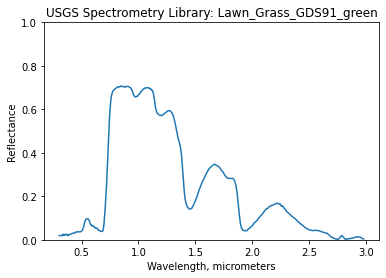

In [117]:
plt.plot(green_grass.data[0], green_grass.data[1])
plt.ylim(0,1)
plt.xlabel('Wavelength, micrometers')
plt.ylabel('Reflectance')
plt.title('USGS Spectrometry Library: Lawn_Grass_GDS91_green')
plt.show()

### Test Case: Greeneville, TN 

In [8]:
poly = Polygon([
        [-82.84917784355127,36.16859176687424],
        [-82.76369047782862,36.16859176687424],
        [-82.76369047782862,36.22372698662217],
        [-82.84917784355127,36.22372698662217],
        [-82.84917784355127,36.16859176687424]
    ]) #can search with upper/lower bounds
center = poly.centroid 

In [28]:
uname = os.environ.get('landsat_api_username') # registered account
usgs_api = lsxp.api.API(uname, keyring.get_password('m2m.cr.usgs.gov', uname)) # literally created a generic credential and stored it in there

In [29]:
# just looking to check what landsatxplore is hitting: https://m2m.cr.usgs.gov/api/docs/json/
usgs_api.__dict__['session'].__dict__['cookies'].__dict__['_cookies']['m2m.cr.usgs.gov']['/']

{'m2m-production': Cookie(version=0, name='m2m-production', value='l3s3c6lbilig83un40ln8ud81o', port=None, port_specified=False, domain='m2m.cr.usgs.gov', domain_specified=False, domain_initial_dot=False, path='/', path_specified=True, secure=True, expires=1698462012, discard=False, comment=None, comment_url=None, rest={'HttpOnly': None}, rfc2109=False),
 'fwb': Cookie(version=0, name='fwb', value='3d468456d79ddb61eeddde07376b3c65', port=None, port_specified=False, domain='m2m.cr.usgs.gov', domain_specified=False, domain_initial_dot=False, path='/', path_specified=True, secure=True, expires=1698458712, discard=False, comment=None, comment_url=None, rest={'HttpOnly': None}, rfc2109=False),
 'cookiesession1': Cookie(version=0, name='cookiesession1', value='678A3E7E74593594AB200881C9E854B4', port=None, port_specified=False, domain='m2m.cr.usgs.gov', domain_specified=False, domain_initial_dot=False, path='/', path_specified=True, secure=False, expires=1729994423, discard=False, comment=Non

In [30]:
scenes = usgs_api.search(
    dataset='landsat_ot_c2_l2', # this is landsats OT coverage 2 level 2 - atmospherically corrected
    latitude=center.y,
    longitude=center.x,
    start_date='2015-01-01',
    end_date='2016-01-01',
    max_cloud_cover=50
)

In [118]:
scenes

[{'cloud_cover': 0,
  'entity_id': 'LC80190352015353LGN01',
  'display_id': 'LC08_L2SP_019035_20151219_20200908_02_T1',
  'ordering_id': 'None',
  'landsat_product_id': 'LC08_L1TP_019035_20151219_20200908_02_T1',
  'landsat_scene_id': 'LC80190352015353LGN01',
  'acquisition_date': datetime.datetime(2015, 12, 19, 0, 0),
  'collection_category': datetime.datetime(2023, 10, 1, 0, 0),
  'collection_number': 2,
  'wrs_path': 19,
  'wrs_row': 35,
  'target_wrs_path': 19,
  'target_wrs_row': 35,
  'nadir-off_nadir': 'NADIR',
  'roll_angle': 0.0,
  'date_product_generated': datetime.datetime(2020, 9, 8, 0, 0),
  'start_time': datetime.datetime(2015, 12, 19, 16, 11, 50, 708958),
  'stop_time': datetime.datetime(2015, 12, 19, 16, 12, 22, 478954),
  'station_id': 'LGN',
  'day-night_indicator': 'DAY',
  'land_cloud_cover': 0.07,
  'scene_cloud_cover': 0.07,
  'ground_control_points_model': 942,
  'ground_control_points_version': 5,
  'geometric_rmse_model': 7.724,
  'geometric_rmse_model_x': 4.31

In [14]:
gdf = gpd.GeoDataFrame.from_records(scenes)
gdf = gdf.set_geometry('spatial_coverage')
gdf = gdf.set_crs(4326)

<AxesSubplot:>

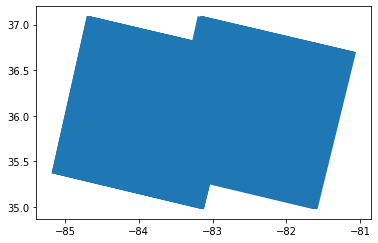

In [18]:
gdf.plot()

##### let's only get the exteriors of the polygons so it doesn't fill and we get a better idea

In [52]:
gdf['geometry'] = gdf['spatial_coverage'].exterior # exterior is linearring

<AxesSubplot:>

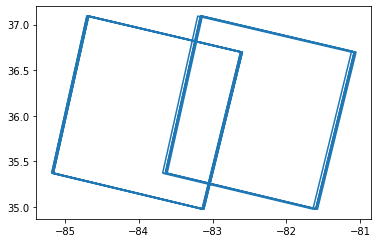

In [53]:
gdf['geometry'].plot()

### quickly save as KML to look at the coverages in google earth

In [19]:
gdf[['spatial_coverage', 'cloud_cover', 'entity_id', 'display_id', 'ordering_id', 'landsat_product_id']].to_file('coverages.kml', driver='KML')

Honestly any of these images would work -> let's just do `LC08_L1TP_018035_20150923_20200908_02_T1` because it has some cloud cover as well.

In [26]:
image = 'LC08_L1TP_018035_20150923_20200908_02_T1'
gdf[gdf['landsat_product_id']==image].iloc[0] # preview the image

cloud_cover                                                                     34
entity_id                                                    LC80180352015266LGN01
display_id                                LC08_L2SP_018035_20150923_20200908_02_T1
ordering_id                                                                   None
landsat_product_id                        LC08_L1TP_018035_20150923_20200908_02_T1
landsat_scene_id                                             LC80180352015266LGN01
acquisition_date                                               2015-09-23 00:00:00
collection_category                                            2023-10-01 00:00:00
collection_number                                                                2
wrs_path                                                                        18
wrs_row                                                                         35
target_wrs_path                                                                 18
targ

### Download the image into data folder

In [39]:
engine = ee.EarthExplorer(uname, keyring.get_password('m2m.cr.usgs.gov', uname))

In [43]:
engine.download('LC80180352015266LGN01', output_dir='../data')

Download failed with dataset id 1 of 2. Re-trying with the next one.


1.20GB [01:47, 12.0MB/s]                            


'../data\\LC08_L1TP_018035_20150923_20200908_02_T1.tar'

### Load in the MTL file so we can access projection info, image info, rescaling factors, etc

In [133]:
mtl = load(open(r'../data/landsat/LC08_L1TP_018035_20150923_20200908_02_T1_MTL.json'))['LANDSAT_METADATA_FILE']

In [601]:
green = rasterio.open(r'../data/landsat/LC08_L1TP_018035_20150923_20200908_02_T1_B3.TIF')
green_profile = green.profile
green_profile['dtype'] = np.float64
sun_correction = sin(float(mtl['IMAGE_ATTRIBUTES']['SUN_ELEVATION']) * pi/180)
mp = float(mtl['LEVEL1_RADIOMETRIC_RESCALING']['REFLECTANCE_MULT_BAND_3'])
ap = float(mtl['LEVEL1_RADIOMETRIC_RESCALING']['REFLECTANCE_ADD_BAND_3'])
green_band = green.read(1)
green_reflectance = mp*green_band + ap
green_reflectance /= sun_correction

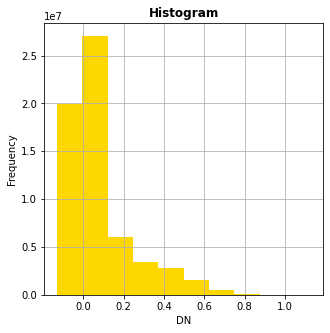

In [602]:
fig, axhist = plt.subplots(1, 1, figsize=(5, 5))
show_hist(green_reflectance, ax=axhist)
axhist.get_legend().remove()
plt.show()

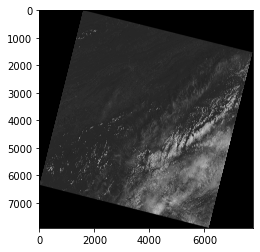

In [603]:
plt.imshow(green_reflectance, cmap='gray')

### Let's find our green grass in this now using a very simple technique to double check some logic
Landsat 8's Band 3 collects from .53 - .59 microns. Our green grass sample was collected from .2 to 3 microns using a Beckman spectrometer. We only care about values from .53 - .59

In [604]:
green_grass.spectrometer

'Spectrometer(spectrometer_code=BECK, wavelength_min=0.2,wavelength_max=3,bandpass_descrip=Standard setting,model_descrip=Beckman 5270)'

In [605]:
mask = (green_grass.data[0]>=.53) & (green_grass.data[0] <= .59) # restrict to .53 and .59

##### Even within the .53 - .59 range that are a variety of values that the green grass can assume based on the green grass sample.

##### Let's label anything between the min and max of this array as grass in the image.

In [606]:
green_grass_min = green_grass.data[1][mask].min()
green_grass_max = green_grass.data[1][mask].max()
print(f'Max: {green_grass_max:.4f} and Min: {green_grass_min:.4f}')

Max: 0.0973 and Min: 0.0668


In [607]:
grass_mask = np.logical_and((green_reflectance>=green_grass_min),(green_reflectance<=green_grass_max))
not_grass_mask = np.logical_or((green_reflectance<green_grass_min),(green_reflectance>green_grass_max))

In [608]:
green_reflectance[grass_mask] = 1
green_reflectance[not_grass_mask] = 0

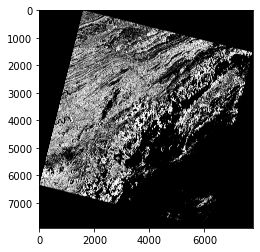

In [609]:
plt.imshow(green_reflectance, cmap='gray')
plt.show()

In [612]:
with rasterio.open('../data/results/green_grass_band3_calc.tif', 'w', **green_profile) as f:
    f.write(green_reflectance, 1)

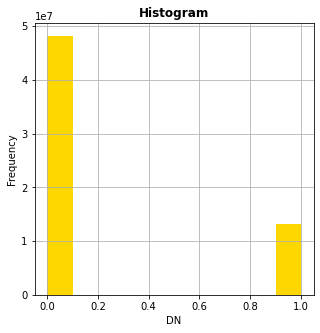

In [613]:
fig, axhist = plt.subplots(1, 1, figsize=(5, 5))
show_hist(green_reflectance, ax=axhist)
axhist.get_legend().remove()
plt.show()

### Now we are not capturing clouds, water, or most of the mountainous features. However, we are capturing some of these features. Including a NIR band will help

In [671]:
nir = rasterio.open(r'../data/landsat/LC08_L1TP_018035_20150923_20200908_02_T1_B5.TIF')
nir_profile = nir.profile
nir_profile['dtype'] = np.float64
sun_correction = sin(float(mtl['IMAGE_ATTRIBUTES']['SUN_ELEVATION']) * pi/180)
mp = float(mtl['LEVEL1_RADIOMETRIC_RESCALING']['REFLECTANCE_MULT_BAND_5'])
ap = float(mtl['LEVEL1_RADIOMETRIC_RESCALING']['REFLECTANCE_ADD_BAND_5'])
nir_band = nir.read(1)
nir_reflectance = mp*nir_band + ap
nir_reflectance /= sun_correction

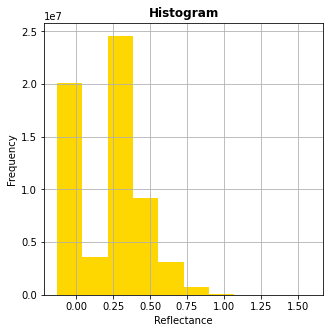

In [672]:
fig, axhist = plt.subplots(1, 1, figsize=(5, 5))
show_hist(nir_reflectance, ax=axhist)
axhist.get_legend().remove()
plt.xlabel('Reflectance')
plt.show()

In [673]:
green_grass_min = .3
green_grass_max = .75
print(f'Max: {green_grass_max:.4f} and Min: {green_grass_min:.4f}')

Max: 0.7500 and Min: 0.3000


In [674]:
grass_mask = np.logical_and((nir_reflectance>=green_grass_min),(nir_reflectance<=green_grass_max))
not_grass_mask = np.logical_or((nir_reflectance<green_grass_min),(nir_reflectance>green_grass_max))
nir_reflectance[grass_mask] = 1
nir_reflectance[not_grass_mask] = 0

In [677]:
with rasterio.open('../data/results/green_Grass_band5.tif', 'w', **nir_profile) as f:
    f.write(nir_reflectance, 1)

In [678]:
combined = np.stack([green_reflectance, nir_reflectance], axis=1)
grass_mask = np.logical_and((combined[:,0,:]==1),(combined[:,1,:]==1))
grass = np.zeros(nir_reflectance.shape)
grass[grass_mask] = 1

In [680]:
with rasterio.open('../data/results/green_grass_band3_5.tif', 'w', **nir_profile) as f:
    f.write(grass, 1)